The data comes from https://firstratedata.com/, but their free samples seem to be tied to the day you request to have them.

I tried to find stocks in different fields.

I didn't feel the need to test for trends because my window is so short (just a couple of weeks)

I chose to use GRU based on this paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9141105/#:~:text=2.4.-,Recurrent%20Neural%20Networks%20(RNNs),time%20intervals%20or%20time%20steps. Long Term Short Term networks may also work but they may be time intensive. "GRUs are simplified version of LSTMs that use single “update gate” to control the flow of information into the memory cell. GRUs are easier to train and faster to run than LSTMs, but they may not be as effective at storing and accessing long-term dependencies."

I have access to 10 days worth of minute-to-minute data, for 7 stocks in different fields. I used a "walk forward" stratedy to train my models: giving it two and a half days worth of data (from 8am day 1 to 11:59am on day 3) and then asked it to predict the price at noon, 2pm, and the closing price at 4pm on day 3. Once the model was tuned, I had it work from day 1 into the middle of day 4, and so on until the final day's worth of data was reached (the test set).

Remember: Convert change in price to percentage

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
#!pip install numpy==1.23.0
import numpy as np

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

from datetime import datetime as dt

from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import GRU
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

In [4]:
print(np.__version__)

1.25.2


In [5]:
df_aal = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/AAL_1min_sample.csv")
df_fdx = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/FDX_1min_sample.csv")
df_fis = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/FIS_1min_sample.csv")
df_mcy = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/M_1min_sample.csv")
df_spr = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/S_1min_sample.csv")
df_sbx = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/SBUX_1min_sample.csv")
df_tsl = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/TSLA_1min_sample.csv")

all_dfs = [df_aal, df_fdx, df_fis, df_mcy, df_sbx, df_spr, df_tsl]

In [6]:
for df in all_dfs:
    print(len(df))

5700
4231
4396
5595
4776
5050
10005


In [7]:
for df in all_dfs:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

In [8]:
# for df in all_dfs:
#     print(df.isnull().sum())
#     print("\n")

Next, I am just looking for the latest time that any of my stocks began to track their prices and the earliest time that any of them stopped tracking their prices. This way, I can make all of my data uniform in length.

In [9]:
for df in all_dfs:
    print(df["timestamp"][0])

2024-02-26 04:03:00
2024-02-26 06:09:00
2024-02-26 06:06:00
2024-02-26 04:41:00
2024-02-26 08:00:00
2024-02-26 04:00:00
2024-02-26 04:00:00


In [10]:
for df in all_dfs:
    print(df["timestamp"].iloc[-1])

2024-03-11 19:44:00
2024-03-11 18:11:00
2024-03-11 16:00:00
2024-03-11 19:39:00
2024-03-11 19:04:00
2024-03-11 19:38:00
2024-03-11 19:54:00


So 8am on the 26th and 4pm on the 11th.

In [11]:
for df in all_dfs:
    df.set_index('timestamp', inplace=True)

In [12]:
for i, df in enumerate(all_dfs):
    all_dfs[i] = df.resample("1min").asfreq().ffill()

In [13]:
for i, df in enumerate(all_dfs):
    all_dfs[i] = df['2024-02-26 08:00' : "2024-03-11 16:00" ]

In [14]:
for i, df in enumerate(all_dfs):
    all_dfs[i].drop(["high", "low", "close"], axis = 1, inplace = True)

<ipython-input-14-06eb2f43abe5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs[i].drop(["high", "low", "close"], axis = 1, inplace = True)


In [15]:
seven_dfs = pd.concat(all_dfs, axis=1)

In [16]:
cols = ["open_1", "volume_1", "open_2", "volume_2", "open_3",
                   "volume_3", "open_4", "volume_4", "open_5", "volume_5",
                   "open_6", "volume_6", "open_7", "volume_7"]

seven_dfs.set_axis(cols, axis = 1, inplace = True)

<ipython-input-16-af5447aa6638>:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  seven_dfs.set_axis(cols, axis = 1, inplace = True)


In [17]:
# Getting the first one and a half days of data for the initial training set,
# Then using that to scale all of my data.


train_36_hrs = seven_dfs['2024-02-26 08:00' : "2024-02-28 12:00" ]

scaler = StandardScaler()

train_36_hrs[cols] = scaler.fit(train_36_hrs[cols])
seven_dfs[cols] = scaler.transform(seven_dfs[cols])

<ipython-input-17-5950431c8b46>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_36_hrs[cols] = scaler.fit(train_36_hrs[cols])


In [18]:
seven_dfs["hour"] = np.nan
for i in range(len(seven_dfs)):
  seven_dfs["hour"][i] = seven_dfs.index[i].hour

seven_dfs["day"] = np.nan
for i in range(len(seven_dfs)):
  seven_dfs["day"][i] = seven_dfs.index[i].dayofweek

In [19]:
seven_dfs.drop(seven_dfs[(seven_dfs["hour"] < 8) |
                        (seven_dfs["hour"] > 15)].index, inplace = True)
seven_dfs.drop(seven_dfs[seven_dfs["day"] > 4].index, inplace = True)

In [20]:
len(seven_dfs)

5280

<Axes: xlabel='timestamp'>

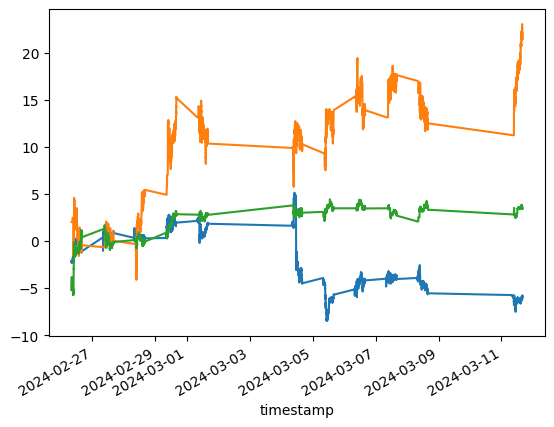

In [21]:
seven_dfs.open_1.plot()
seven_dfs.open_2.plot()
seven_dfs.open_3.plot()

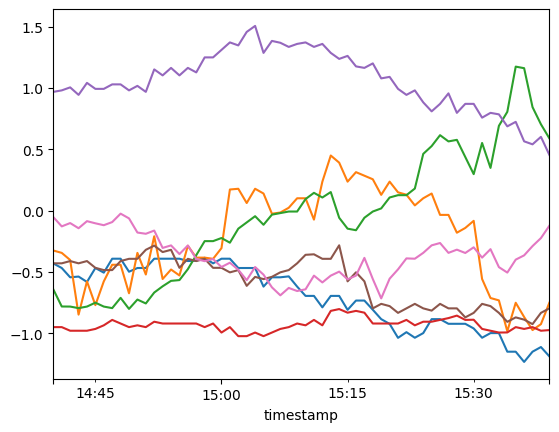

In [22]:
prices = ["open_1", "open_2", "open_3", "open_4", "open_5", "open_6", "open_7"]
for price in prices:
  seven_dfs[price][400:460].plot()

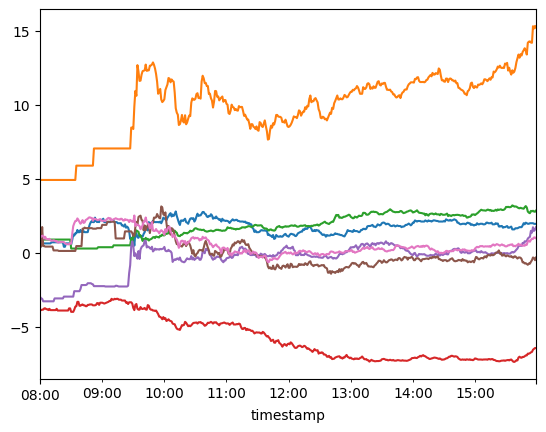

In [23]:
for price in prices:
  seven_dfs[price][1440:1920].plot()

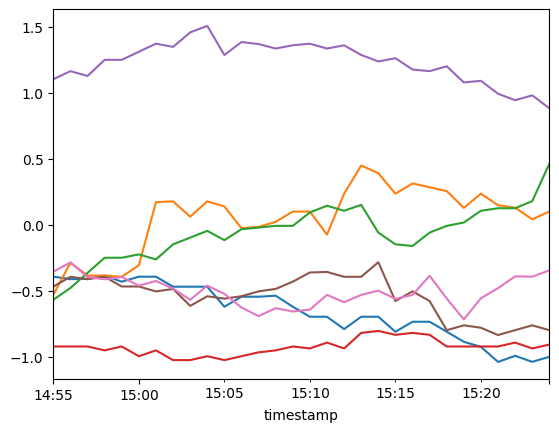

In [24]:
for price in prices:
  seven_dfs[price][415:445].plot()

In [25]:
seven_dfs.drop(seven_dfs[seven_dfs["hour"] < 9].index, inplace = True)

In [26]:
len(seven_dfs)

4620

In [27]:
seven_dfs.head()

,open_1,volume_1,open_2,volume_2,open_3,volume_3,open_4,volume_4,open_5,volume_5,open_6,volume_6,open_7,volume_7,hour,day
timestamp,,,,,,,,,,,,,,,,
2024-02-26 09:00:00,-1.718825,-0.227184,2.481364,-0.532078,-4.453081,-0.248041,-0.552663,-0.246766,3.020294,-0.089569,-3.440951,-0.079279,-3.676290,-0.515833,9.0,0.0
2024-02-26 09:01:00,-1.718825,-0.227184,2.481364,-0.532078,-4.453081,-0.169387,-0.552663,-0.246766,3.020294,-0.089569,-3.440951,-0.079279,-3.676290,-0.509867,9.0,0.0
2024-02-26 09:02:00,-1.718825,-0.227184,2.481364,-0.532078,-4.453081,-0.169387,-0.552663,-0.246766,3.020294,-0.089569,-3.440951,-0.079279,-3.691343,-0.499595,9.0,0.0
2024-02-26 09:03:00,-1.718825,-0.227184,2.481364,-0.532078,-4.453081,-0.169387,-0.523226,-0.225539,3.020294,-0.089569,-3.440951,-0.079279,-3.671273,-0.508306,9.0,0.0
2024-02-26 09:04:00,-2.022018,-0.228474,2.481364,-0.532078,-4.453081,-0.169387,-0.523226,-0.225539,3.020294,-0.089569,-3.440951,-0.079279,-3.696360,-0.457163,9.0,0.0


In [28]:
# Code repurposed from Greg Hogg: https://www.youtube.com/watch?v=c0k-YLQGKjY
def df_to_Xy(df, window):
  df_np = df.to_numpy()
  X = []
  y = []
  for i in range(0, len(df)-window, window):
    row = [a for a in df_np[i:i+window]]
    X.append(row)
    y.append(df_np[i+window][[0,2,4,6,8,10,12]]) # y is just the 7 price cols
  return np.array(X), np.array(y,dtype=np.float32)

In [29]:
X25, y25 = df_to_Xy(seven_dfs, 25)
X34, y34 = df_to_Xy(seven_dfs, 34)
X45, y45 = df_to_Xy(seven_dfs, 45)
X60, y60 = df_to_Xy(seven_dfs, 60)

When I first started building these, before I fully realized how I wanted the iteration process to go, my intervals were 34, 45, 60, and 80. But it became quite apparent that the 80 minute intervals were beyond saving (presumably because they didn't have enough instances of the target variable in the training data). So I added the 25 minute one in its place.

In [30]:
len(y25)

184

In [31]:
X_train25, y_train25 = X25[:129], y25[:129] #Just over 70% of the data
X_val25, y_val25 = X25[129:157], y25[129:157]
X_test25, y_test25 = X25[157:], y25[157:]

X_train34, y_train34 = X34[:95], y34[:95]
X_val34, y_val34 = X34[95:115], y34[95:115]
X_test34, y_test34 = X34[115:], y34[115:]

X_train45, y_train45 = X45[:72], y45[:72]
X_val45, y_val45 = X45[72:87], y45[72:87]
X_test45, y_test45 = X45[87:], y45[87:]

X_train60, y_train60 = X60[:55], y60[:55]
X_val60, y_val60 = X60[55:65], y60[55:65]
X_test60, y_test60 = X60[65:], y60[65:]

In [32]:
def pred_plot_col(model, X, y, col):
  y = y[:,col]
  preds = model.predict(X)[:,col].flatten()
  df = pd.DataFrame(data={"Predictions":preds, "Actuals":y})
  plt.plot(df["Predictions"][:], label = "Predictions")
  plt.plot(df["Actuals"][:], label = "Actuals")
  plt.legend()
  return mse(y, preds)

def pred_plot_all(model, X, y):
  fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)
  fig.set_figheight(22)
  fig.set_figwidth(15)
  axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
  for i, ax in enumerate(axes):
    actual = y[:,i].flatten()
    preds = model.predict(X)[:,i].flatten()
    ax = ax
    ax.plot(preds)
    ax.plot(actual)
    ax.legend(["Prediction", "Actual"])
    plt.legend()

In [33]:
def plot_error(X):
  hist_dict = X.history
  rmse = hist_dict["root_mean_squared_error"]
  v_rmse = hist_dict["val_root_mean_squared_error"]
  df = pd.DataFrame(data={"Train_error":rmse, "Val_Error":v_rmse})
  plt.plot(df["Train_error"][:], label = "Train error")
  plt.plot(df["Val_Error"][:], label = "Val Error")
  plt.legend()

In [35]:
the_X_trains = [X_train25, X_train34, X_train45, X_train60]
the_y_trains = [y_train25, y_train34, y_train45, y_train60]

the_X_vals = [X_val25, X_val34, X_val45, X_val60]
the_y_vals = [y_val25, y_val34, y_val45, y_val60]


## Instantiating every model, and setting their checkpoints

# slow/small
mod_25_ss = Sequential()
mod_34_ss = Sequential()
mod_45_ss = Sequential()
mod_60_ss = Sequential()

cp25_ss = ModelCheckpoint("model_25_ss/", save_best_only=True)
cp34_ss = ModelCheckpoint("model_34_ss/", save_best_only=True)
cp45_ss = ModelCheckpoint("model_45_ss/", save_best_only=True)
cp60_ss = ModelCheckpoint("model_60_ss/", save_best_only=True)

mods_ss = [mod_25_ss, mod_34_ss, mod_45_ss, mod_60_ss]

cps_ss = [cp25_ss, cp34_ss, cp45_ss, cp60_ss]

# slow/big
mod_25_sb = Sequential()
mod_34_sb = Sequential()
mod_45_sb = Sequential()
mod_60_sb = Sequential()

cp25_sb = ModelCheckpoint("model_25_sb/", save_best_only=True)
cp34_sb = ModelCheckpoint("model_34_sb/", save_best_only=True)
cp45_sb = ModelCheckpoint("model_45_sb/", save_best_only=True)
cp60_sb = ModelCheckpoint("model_60_sb/", save_best_only=True)

mods_sb = [mod_25_sb, mod_34_sb, mod_45_sb, mod_60_sb]

cps_sb = [cp25_sb, cp34_sb, cp45_sb, cp60_sb]

# fast/small
mod_25_fs = Sequential()
mod_34_fs = Sequential()
mod_45_fs = Sequential()
mod_60_fs = Sequential()

cp25_fs = ModelCheckpoint("model_25_fs/", save_best_only=True)
cp34_fs = ModelCheckpoint("model_34_fs/", save_best_only=True)
cp45_fs = ModelCheckpoint("model_45_fs/", save_best_only=True)
cp60_fs = ModelCheckpoint("model_60_fs/", save_best_only=True)

mods_fs = [mod_25_fs, mod_34_fs, mod_45_fs, mod_60_fs]

cps_fs = [cp25_fs, cp34_fs, cp45_fs, cp60_fs]

# fast/big
mod_25_fb = Sequential()
mod_34_fb = Sequential()
mod_45_fb = Sequential()
mod_60_fb = Sequential()

cp25_fb = ModelCheckpoint("model_25_fb/", save_best_only=True)
cp34_fb = ModelCheckpoint("model_34_fb/", save_best_only=True)
cp45_fb = ModelCheckpoint("model_45_fb/", save_best_only=True)
cp60_fb = ModelCheckpoint("model_60_fb/", save_best_only=True)

mods_fb = [mod_25_fb, mod_34_fb, mod_45_fb, mod_60_fb]

cps_fb = [cp25_fb, cp34_fb, cp45_fb, cp60_fb]

In [ ]:
for i, n in enumerate([25, 34, 45, 60]):
  mods_ss[i].add(InputLayer((n,16)))
  mods_ss[i].add(GRU(64))
  the_models[i].add(Dense(16, "relu"))
  the_models[i].add(Dense(14, "relu"))
  the_models[i].add(Dense(7, "linear"))

  the_models[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.0001),
                        metrics=[RootMeanSquaredError()])

  the_models[i].fit(the_X_trains[i], the_y_trains[i], validation_data=(
      the_X_vals[i], the_y_vals[i]), epochs = 25,
      callbacks = [the_cps[i], EarlyStopping(patience=5)])

In [165]:
model_25_0 = Sequential()
model_25_0.add(InputLayer((25,16)))
model_25_0.add(GRU(64))
model_25_0.add(Dense(16, "relu"))
model_25_0.add(Dense(14, "relu"))
model_25_0.add(Dense(7, "linear"))

cp_25_0 = ModelCheckpoint("model_25_0/", save_best_only=True)

model_25_0.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.0001),
                 metrics=[RootMeanSquaredError()])


model_34_0 = Sequential()
model_34_0.add(InputLayer((34,16)))
model_34_0.add(GRU(64))
model_34_0.add(Dense(16, "relu"))
model_34_0.add(Dense(14, "relu"))
model_34_0.add(Dense(7, "linear"))

cp_34_0 = ModelCheckpoint("model_34_0/", save_best_only=True)

model_34_0.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.0001),
                 metrics=[RootMeanSquaredError()])


model_45_0 = Sequential()
model_45_0.add(InputLayer((45,16)))
model_45_0.add(GRU(64))
model_45_0.add(Dense(16, "relu"))
model_45_0.add(Dense(14, "relu"))
model_45_0.add(Dense(7, "linear"))

cp_45_0 = ModelCheckpoint("model_45_0/", save_best_only=True)

model_45_0.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.0001),
                 metrics=[RootMeanSquaredError()])


model_60_0 = Sequential()
model_60_0.add(InputLayer((60,16)))
model_60_0.add(GRU(64))
model_60_0.add(Dense(16, "relu"))
model_60_0.add(Dense(14, "relu"))
model_60_0.add(Dense(7, "linear"))

cp_60_0 = ModelCheckpoint("model_60_0/", save_best_only=True)

model_60_0.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.0001),
                 metrics=[RootMeanSquaredError()])

In [168]:
hist_25_0 = model_25_0.fit(X_train25, y_train25, validation_data=(X_val25,
        y_val25), epochs = 30, callbacks = [cp_25_0, EarlyStopping(patience=3, start_from_epoch=5)])

Epoch 1/30
5/5 [==============================] - 3s 845ms/step - loss: 25.4105 - root_mean_squared_error: 5.0409 - val_loss: 66.6809 - val_root_mean_squared_error: 8.1658
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 25.2833 - root_mean_squared_error: 5.0283

KeyboardInterrupt: 

In [167]:
hist_34_0 = model_34_0.fit(X_train34, y_train34, validation_data=(X_val34, y_val34),
            epochs = 30, callbacks = [cp_34_0, EarlyStopping(patience=3, start_from_epoch=5)])

Epoch 1/30
3/3 [==============================] - 6s 2s/step - loss: 26.6253 - root_mean_squared_error: 5.1600 - val_loss: 70.1293 - val_root_mean_squared_error: 8.3743
Epoch 2/30
1/3 [=========>....................] - ETA: 0s - loss: 34.4936 - root_mean_squared_error: 5.8731

KeyboardInterrupt: 

In [ ]:
hist_45_0 = model_45_0.fit(X_train45, y_train45, validation_data=(X_val45, y_val45),
            epochs = 30, callbacks = [cp_45_0, EarlyStopping(patience=3, start_from_epoch=5)])

In [ ]:
hist_60_0 = model_60_0.fit(X_train60, y_train60, validation_data=(X_val60, y_val60),
            epochs = 30, callbacks = [cp_60_0, EarlyStopping(patience=3, start_from_epoch=5)])

Next: the second iteration (few layers, large learning rate)

In [37]:
model_25_1 = Sequential()
model_25_1.add(InputLayer((25,16)))
model_25_1.add(GRU(64))
model_25_1.add(Dense(16, "relu"))
model_25_1.add(Dense(14, "relu"))
model_25_1.add(Dense(7, "linear"))

cp_25_1 = ModelCheckpoint("model_25_1/", save_best_only=True)

model_25_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.01),
                 metrics=[RootMeanSquaredError()])


model_34_1 = Sequential()
model_34_1.add(InputLayer((34,16)))
model_34_1.add(GRU(64))
model_34_1.add(Dense(16, "relu"))
model_34_1.add(Dense(14, "relu"))
model_34_1.add(Dense(7, "linear"))

cp_34_1 = ModelCheckpoint("model_34_1/", save_best_only=True)

model_34_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.01),
                 metrics=[RootMeanSquaredError()])


model_45_1 = Sequential()
model_45_1.add(InputLayer((45,16)))
model_45_1.add(GRU(64))
model_45_1.add(Dense(16, "relu"))
model_45_1.add(Dense(14, "relu"))
model_45_1.add(Dense(7, "linear"))

cp_45_1 = ModelCheckpoint("model_45_1/", save_best_only=True)

model_45_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.01),
                 metrics=[RootMeanSquaredError()])


model_60_1 = Sequential()
model_60_1.add(InputLayer((60,16)))
model_60_1.add(GRU(64))
model_60_1.add(Dense(16, "relu"))
model_60_1.add(Dense(14, "relu"))
model_60_1.add(Dense(7, "linear"))

cp_60_1 = ModelCheckpoint("model_60_1/", save_best_only=True)

model_60_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.01),
                 metrics=[RootMeanSquaredError()])

In [38]:
hist_25_1 = model_25_1.fit(X_train25, y_train25, validation_data=(X_val25,
        y_val25), epochs = 30, callbacks = [cp_25_1, EarlyStopping(patience=3, start_from_epoch=5)])

Epoch 1/30
5/5 [==============================] - 8s 1s/step - loss: 25.8869 - root_mean_squared_error: 5.0879 - val_loss: 64.6960 - val_root_mean_squared_error: 8.0434
Epoch 2/30
5/5 [==============================] - 3s 867ms/step - loss: 21.8813 - root_mean_squared_error: 4.6778 - val_loss: 55.2567 - val_root_mean_squared_error: 7.4335
Epoch 3/30
5/5 [==============================] - 5s 1s/step - loss: 17.0922 - root_mean_squared_error: 4.1343 - val_loss: 37.5714 - val_root_mean_squared_error: 6.1295
Epoch 4/30
5/5 [==============================] - 4s 920ms/step - loss: 11.1552 - root_mean_squared_error: 3.3399 - val_loss: 22.2467 - val_root_mean_squared_error: 4.7166
Epoch 5/30
5/5 [==============================] - 4s 897ms/step - loss: 7.1851 - root_mean_squared_error: 2.6805 - val_loss: 11.2814 - val_root_mean_squared_error: 3.3588
Epoch 6/30
5/5 [==============================] - 5s 1s/step - loss: 4.6659 - root_mean_squared_error: 2.1601 - val_loss: 5.3755 - val_root_mean_sq

In [39]:
hist_34_1 = model_34_1.fit(X_train34, y_train34, validation_data=(X_val34, y_val34),
            epochs = 30, callbacks = [cp_34_1, EarlyStopping(patience=3, start_from_epoch=5)])

Epoch 1/30
3/3 [==============================] - 7s 2s/step - loss: 25.5552 - root_mean_squared_error: 5.0552 - val_loss: 55.5626 - val_root_mean_squared_error: 7.4540
Epoch 2/30
3/3 [==============================] - 4s 2s/step - loss: 20.5509 - root_mean_squared_error: 4.5333 - val_loss: 38.7713 - val_root_mean_squared_error: 6.2267
Epoch 3/30
3/3 [==============================] - 5s 3s/step - loss: 15.0001 - root_mean_squared_error: 3.8730 - val_loss: 23.4288 - val_root_mean_squared_error: 4.8403
Epoch 4/30
3/3 [==============================] - 4s 2s/step - loss: 10.4056 - root_mean_squared_error: 3.2258 - val_loss: 10.6287 - val_root_mean_squared_error: 3.2602
Epoch 5/30
3/3 [==============================] - 4s 2s/step - loss: 7.1185 - root_mean_squared_error: 2.6680 - val_loss: 5.2971 - val_root_mean_squared_error: 2.3016
Epoch 6/30
3/3 [==============================] - 5s 2s/step - loss: 5.7155 - root_mean_squared_error: 2.3907 - val_loss: 4.1952 - val_root_mean_squared_erro

In [40]:
hist_45_1 = model_45_1.fit(X_train45, y_train45, validation_data=(X_val45, y_val45),
            epochs = 30, callbacks = [cp_45_1, EarlyStopping(patience=3, start_from_epoch=5)])

Epoch 1/30
3/3 [==============================] - 7s 2s/step - loss: 25.2452 - root_mean_squared_error: 5.0245 - val_loss: 43.8865 - val_root_mean_squared_error: 6.6247
Epoch 2/30
3/3 [==============================] - 3s 2s/step - loss: 15.4830 - root_mean_squared_error: 3.9348 - val_loss: 18.6793 - val_root_mean_squared_error: 4.3220
Epoch 3/30
3/3 [==============================] - 4s 2s/step - loss: 8.0965 - root_mean_squared_error: 2.8454 - val_loss: 7.3964 - val_root_mean_squared_error: 2.7196
Epoch 4/30
3/3 [==============================] - 4s 2s/step - loss: 6.3061 - root_mean_squared_error: 2.5112 - val_loss: 6.3595 - val_root_mean_squared_error: 2.5218
Epoch 5/30
3/3 [==============================] - 4s 2s/step - loss: 4.3453 - root_mean_squared_error: 2.0845 - val_loss: 5.5703 - val_root_mean_squared_error: 2.3601
Epoch 6/30
3/3 [==============================] - 4s 2s/step - loss: 3.1857 - root_mean_squared_error: 1.7848 - val_loss: 4.8471 - val_root_mean_squared_error: 2

In [41]:
hist_60_1 = model_60_1.fit(X_train60, y_train60, validation_data=(X_val60, y_val60),
            epochs = 30, callbacks = [cp_60_1, EarlyStopping(patience=3, start_from_epoch=5)])

Epoch 1/30
2/2 [==============================] - 7s 4s/step - loss: 27.7470 - root_mean_squared_error: 5.2675 - val_loss: 57.5881 - val_root_mean_squared_error: 7.5887
Epoch 2/30
2/2 [==============================] - 4s 4s/step - loss: 22.7367 - root_mean_squared_error: 4.7683 - val_loss: 43.4101 - val_root_mean_squared_error: 6.5886
Epoch 3/30
2/2 [==============================] - 5s 5s/step - loss: 18.2478 - root_mean_squared_error: 4.2717 - val_loss: 32.5001 - val_root_mean_squared_error: 5.7009
Epoch 4/30
2/2 [==============================] - 4s 4s/step - loss: 14.4530 - root_mean_squared_error: 3.8017 - val_loss: 23.3368 - val_root_mean_squared_error: 4.8308
Epoch 5/30
2/2 [==============================] - 4s 4s/step - loss: 11.5561 - root_mean_squared_error: 3.3994 - val_loss: 15.8292 - val_root_mean_squared_error: 3.9786
Epoch 6/30
2/2 [==============================] - 3s 3s/step - loss: 9.1816 - root_mean_squared_error: 3.0301 - val_loss: 10.7474 - val_root_mean_squared_e

The third iteration (more layers, large learning rate)

In [42]:
model_25_2 = Sequential()
model_25_2.add(InputLayer((25,16)))
model_25_2.add(GRU(64))
model_25_2.add(Dense(16, "relu"))
model_25_2.add(Dense(16, "relu")) #extra layer
model_25_2.add(Dense(15, "relu")) #extra layer
model_25_2.add(Dense(14, "relu"))
model_25_2.add(Dense(7, "linear"))

cp_25_2 = ModelCheckpoint("model_25_2/", save_best_only=True)

model_25_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.01),
                 metrics=[RootMeanSquaredError()])


model_34_2 = Sequential()
model_34_2.add(InputLayer((34,16)))
model_34_2.add(GRU(64))
model_34_2.add(Dense(16, "relu"))
model_34_2.add(Dense(16, "relu"))
model_34_2.add(Dense(15, "relu"))
model_34_2.add(Dense(14, "relu"))
model_34_2.add(Dense(7, "linear"))

cp_34_2 = ModelCheckpoint("model_34_2/", save_best_only=True)

model_34_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.01),
                 metrics=[RootMeanSquaredError()])


model_45_2 = Sequential()
model_45_2.add(InputLayer((45,16)))
model_45_2.add(GRU(64))
model_45_2.add(Dense(16, "relu"))
model_45_2.add(Dense(16, "relu"))
model_45_2.add(Dense(15, "relu"))
model_45_2.add(Dense(14, "relu"))
model_45_2.add(Dense(7, "linear"))

cp_45_2 = ModelCheckpoint("model_45_2/", save_best_only=True)

model_45_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.01),
                 metrics=[RootMeanSquaredError()])


model_60_2 = Sequential()
model_60_2.add(InputLayer((60,16)))
model_60_2.add(GRU(64))
model_60_2.add(Dense(16, "relu"))
model_60_2.add(Dense(16, "relu"))
model_60_2.add(Dense(15, "relu"))
model_60_2.add(Dense(14, "relu"))
model_60_2.add(Dense(7, "linear"))

cp_60_2 = ModelCheckpoint("model_60_2/", save_best_only=True)

model_60_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.01),
                 metrics=[RootMeanSquaredError()])

In [43]:
hist_25_2 = model_25_2.fit(X_train25, y_train25, validation_data=(X_val25, y_val25),
            epochs = 30, callbacks = [cp_25_2, EarlyStopping(patience=3, start_from_epoch=5)])

Epoch 1/30
5/5 [==============================] - 8s 1s/step - loss: 25.5056 - root_mean_squared_error: 5.0503 - val_loss: 64.1353 - val_root_mean_squared_error: 8.0085
Epoch 2/30
5/5 [==============================] - 5s 1s/step - loss: 20.7861 - root_mean_squared_error: 4.5592 - val_loss: 47.6375 - val_root_mean_squared_error: 6.9020
Epoch 3/30
5/5 [==============================] - 5s 1s/step - loss: 14.5552 - root_mean_squared_error: 3.8151 - val_loss: 24.7824 - val_root_mean_squared_error: 4.9782
Epoch 4/30
5/5 [==============================] - 4s 962ms/step - loss: 8.9659 - root_mean_squared_error: 2.9943 - val_loss: 13.1305 - val_root_mean_squared_error: 3.6236
Epoch 5/30
5/5 [==============================] - 4s 957ms/step - loss: 5.9211 - root_mean_squared_error: 2.4333 - val_loss: 6.8223 - val_root_mean_squared_error: 2.6120
Epoch 6/30
5/5 [==============================] - 6s 1s/step - loss: 4.8055 - root_mean_squared_error: 2.1921 - val_loss: 3.9740 - val_root_mean_squared

In [44]:
hist_34_2 = model_34_2.fit(X_train34, y_train34, validation_data=(X_val34, y_val34),
            epochs = 30, callbacks = [cp_34_2, EarlyStopping(patience=3, start_from_epoch=5)])

Epoch 1/30
3/3 [==============================] - 9s 3s/step - loss: 25.9475 - root_mean_squared_error: 5.0939 - val_loss: 63.0521 - val_root_mean_squared_error: 7.9405
Epoch 2/30
3/3 [==============================] - 4s 2s/step - loss: 22.2853 - root_mean_squared_error: 4.7207 - val_loss: 49.4955 - val_root_mean_squared_error: 7.0353
Epoch 3/30
3/3 [==============================] - 5s 2s/step - loss: 16.1241 - root_mean_squared_error: 4.0155 - val_loss: 25.2280 - val_root_mean_squared_error: 5.0227
Epoch 4/30
3/3 [==============================] - 4s 2s/step - loss: 8.5960 - root_mean_squared_error: 2.9319 - val_loss: 7.4546 - val_root_mean_squared_error: 2.7303
Epoch 5/30
3/3 [==============================] - 6s 3s/step - loss: 5.6173 - root_mean_squared_error: 2.3701 - val_loss: 5.9631 - val_root_mean_squared_error: 2.4419
Epoch 6/30
3/3 [==============================] - 0s 69ms/step - loss: 4.2028 - root_mean_squared_error: 2.0501 - val_loss: 7.9333 - val_root_mean_squared_erro

In [45]:
hist_45_2 = model_45_2.fit(X_train45, y_train45, validation_data=(X_val45, y_val45),
            epochs = 30, callbacks = [cp_45_2, EarlyStopping(patience=3, start_from_epoch=5)])

Epoch 1/30
3/3 [==============================] - 8s 3s/step - loss: 26.4870 - root_mean_squared_error: 5.1465 - val_loss: 61.4785 - val_root_mean_squared_error: 7.8408
Epoch 2/30
3/3 [==============================] - 4s 2s/step - loss: 22.8079 - root_mean_squared_error: 4.7758 - val_loss: 44.9913 - val_root_mean_squared_error: 6.7076
Epoch 3/30
3/3 [==============================] - 4s 2s/step - loss: 15.6365 - root_mean_squared_error: 3.9543 - val_loss: 18.8427 - val_root_mean_squared_error: 4.3408
Epoch 4/30
3/3 [==============================] - 6s 3s/step - loss: 7.6987 - root_mean_squared_error: 2.7747 - val_loss: 3.9643 - val_root_mean_squared_error: 1.9910
Epoch 5/30
3/3 [==============================] - 0s 59ms/step - loss: 4.9914 - root_mean_squared_error: 2.2341 - val_loss: 5.4898 - val_root_mean_squared_error: 2.3430
Epoch 6/30
3/3 [==============================] - 0s 71ms/step - loss: 3.8153 - root_mean_squared_error: 1.9533 - val_loss: 8.5563 - val_root_mean_squared_er

In [46]:
hist_60_2 = model_60_2.fit(X_train60, y_train60, validation_data=(X_val60, y_val60),
            epochs = 30, callbacks = [cp_60_2, EarlyStopping(patience=3, start_from_epoch=5)])

Epoch 1/30
2/2 [==============================] - 9s 6s/step - loss: 27.0655 - root_mean_squared_error: 5.2024 - val_loss: 58.8972 - val_root_mean_squared_error: 7.6745
Epoch 2/30
2/2 [==============================] - 5s 5s/step - loss: 21.3659 - root_mean_squared_error: 4.6223 - val_loss: 33.3659 - val_root_mean_squared_error: 5.7763
Epoch 3/30
2/2 [==============================] - 4s 4s/step - loss: 14.4548 - root_mean_squared_error: 3.8019 - val_loss: 11.5994 - val_root_mean_squared_error: 3.4058
Epoch 4/30
2/2 [==============================] - 4s 4s/step - loss: 10.0549 - root_mean_squared_error: 3.1709 - val_loss: 4.9370 - val_root_mean_squared_error: 2.2219
Epoch 5/30
2/2 [==============================] - 5s 5s/step - loss: 7.2923 - root_mean_squared_error: 2.7004 - val_loss: 4.1223 - val_root_mean_squared_error: 2.0303
Epoch 6/30
2/2 [==============================] - 0s 85ms/step - loss: 7.0070 - root_mean_squared_error: 2.6471 - val_loss: 5.0777 - val_root_mean_squared_err

Lastly, the fourth iteration (more layers, small learning rate)

In [47]:
model_25_3 = Sequential()
model_25_3.add(InputLayer((25,16)))
model_25_3.add(GRU(64))
model_25_3.add(Dense(16, "relu"))
model_25_3.add(Dense(16, "relu"))
model_25_3.add(Dense(15, "relu"))
model_25_3.add(Dense(14, "relu"))
model_25_3.add(Dense(7, "linear"))

cp_25_3 = ModelCheckpoint("model_25_3/", save_best_only=True)

model_25_3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.0001),
                 metrics=[RootMeanSquaredError()])

model_34_3 = Sequential()
model_34_3.add(InputLayer((34,16)))
model_34_3.add(GRU(64))
model_34_3.add(Dense(16, "relu"))
model_34_3.add(Dense(16, "relu"))
model_34_3.add(Dense(15, "relu"))
model_34_3.add(Dense(14, "relu"))
model_34_3.add(Dense(7, "linear"))

cp_34_3 = ModelCheckpoint("model_34_3/", save_best_only=True)

model_34_3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.0001),
                 metrics=[RootMeanSquaredError()])


model_45_3 = Sequential()
model_45_3.add(InputLayer((45,16)))
model_45_3.add(GRU(64))
model_45_3.add(Dense(16, "relu"))
model_45_3.add(Dense(16, "relu"))
model_45_3.add(Dense(15, "relu"))
model_45_3.add(Dense(14, "relu"))
model_45_3.add(Dense(7, "linear"))

cp_45_3 = ModelCheckpoint("model_45_3/", save_best_only=True)

model_45_3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.0001),
                 metrics=[RootMeanSquaredError()])


model_60_3 = Sequential()
model_60_3.add(InputLayer((60,16)))
model_60_3.add(GRU(64))
model_60_3.add(Dense(16, "relu"))
model_60_3.add(Dense(16, "relu"))
model_60_3.add(Dense(15, "relu"))
model_60_3.add(Dense(14, "relu"))
model_60_3.add(Dense(7, "linear"))

cp_60_3 = ModelCheckpoint("model_60_3/", save_best_only=True)

model_60_3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=.0001),
                 metrics=[RootMeanSquaredError()])

In [ ]:
hist_25_3 = model_25_3.fit(X_train25, y_train25, validation_data=(X_val25, y_val25),
            epochs = 30, callbacks = [cp_25_3, EarlyStopping(patience=3, start_from_epoch=5)])

In [ ]:
hist_34_3 = model_34_3.fit(X_train34, y_train34, validation_data=(X_val34, y_val34),
            epochs = 30, callbacks = [cp_34_3, EarlyStopping(patience=3, start_from_epoch=5)])

In [ ]:
hist_45_3 = model_45_3.fit(X_train45, y_train45, validation_data=(X_val45, y_val45),
            epochs = 30, callbacks = [cp_45_3, EarlyStopping(patience=3, start_from_epoch=5)])

In [ ]:
hist_60_3 = model_60_3.fit(X_train60, y_train60, validation_data=(X_val60, y_val60),
            epochs = 30, callbacks = [cp_60_3, EarlyStopping(patience=3, start_from_epoch=5)])

In [152]:
# Access the history attribute and store the dictionary
m60_1_dict = hist_60_1.history

# Print the keys
m60_1_dict["loss"]

[27.74701690673828,
 22.736665725708008,
 18.24781036376953,
 14.452984809875488,
 11.556070327758789,
 9.18163776397705,
 7.758383274078369,
 6.533576011657715,
 5.562871932983398,
 4.713470458984375,
 3.943453311920166,
 3.4118025302886963,
 3.089340925216675,
 2.8112525939941406,
 2.5327646732330322]

The versions with the default learning rate were taking much too long to make any headway, and much to my surprise the models with the fewer layers outdid their slightly more complex brethren.

In [161]:
def plot_error(history):
  hist_dict = history.history
  rmse = hist_dict["root_mean_squared_error"]
  v_rmse = hist_dict["val_root_mean_squared_error"]
  df = pd.DataFrame(data={"Train_error":rmse, "Val_Error":v_rmse})
  plt.plot(df["Train_error"][:], label = "Train error")
  plt.plot(df["Val_Error"][:], label = "Val Error")
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

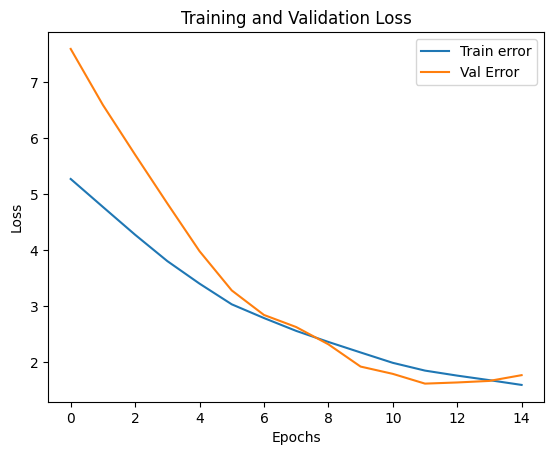

In [162]:
plot_error(hist_60_1)